# Anomaly Detection

In this exercise, we will implement an anomaly detection algorithm to detect anomalous behavior in server computer. The features measure the throughput(mb/s) and latency(ms) of response of each server. While servers were operating, we collected m=307 examples of how they were behaving and thus have an unlabeled dataset. We suspect that the vast majority of these examples are 'normal' examples of the servers operating normally, but there might also be some examples of servers acting anamalously within this dataset. We will use a Gaussian model to detect anomalous examples in our dataset. 

## Part 1: Load Example Dataset

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
data = scipy.io.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
yval = yval.reshape([len(yval),])

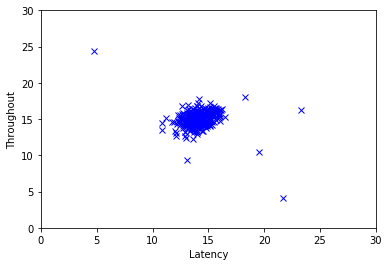

In [3]:
# visualize the example dataset
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency')
plt.ylabel('Throughout')
plt.xlim([0,30])
plt.ylim([0,30])
plt.show()

## Part 2: Estimate the dataset statistics

In [4]:
# estimateGaussian() estimates the parameters of a Gaussian distribution using the data in X
def estimateGaussian(X):
    m = X.shape[0]
    mu = np.mean(X, 0)
    sigma2 = np.sum((X-mu)**2,0)
    sigma2 = sigma2/float(m)
    return mu, sigma2

In [5]:
# multivariateGaussian() computes the probability density function of the multivariate gaussian distribution 
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    X = X-mu
    if len(sigma2.shape) ==1:
        sigma2 = np.diag(sigma2)
    p = ((2*np.pi)**(-k/2))*(np.linalg.det(sigma2)**(-0.5))*np.exp(-0.5*(np.sum(np.dot(X, np.linalg.pinv(sigma2))*X,1)))
    return p

In [6]:
# visualizeFit() visualize the dataset and its estimated distribution 
def visualizeFit(X, mu, sigma2):
    u = np.linspace(0, 35, 71)
    v = np.linspace(0, 35, 71)
    x, y = np.meshgrid(u, v)
    row_num = x.shape[0]
    col_num = x.shape[1]
    z = multivariateGaussian(np.append(x.reshape([71*71,1]),y.reshape([71*71,1]),1), mu, sigma2)
    z = z.reshape([row_num, col_num])
    plt.figure(figsize = (6,6))
    plt.plot(X[:,0], X[:,1], 'bx')
    plt.contour(x,y,z,colors = 'black')
    plt.xlim([0,30])
    plt.ylim([0,30])

In [7]:
# estimate mu and sigma2
mu, sigma2 = estimateGaussian(X)
# returns the density of the multivariate normal at each data point of X
p = multivariateGaussian(X, mu, sigma2)

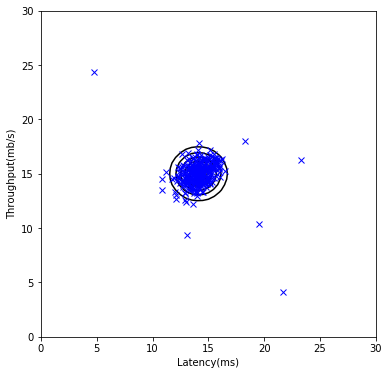

In [8]:
# visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

## Part 3: Find Outliers

Now we will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [9]:
# selectThreshold() find the best threshold (epsilon) to use for selecting outliers
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    epsilons = np.linspace(np.min(pval), np.max(pval), 1000)
    for eps in epsilons:
        predictions = (pval < eps)
        tp = np.sum((predictions == 1) & (yval ==1))
        fp = np.sum((predictions == 1) & (yval ==0))
        fn = np.sum((predictions == 0) & (yval ==1))
        prec = tp/float(tp+fp)
        rec = tp/float(tp+fn)
        F1 = 2*prec*rec/float(prec+rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = eps
    return bestEpsilon, bestF1

In [10]:
# visualizeFit_outliers draw outliers
def visualizeFit_Outliers(X, mu, sigma2, p, epsilon):
    u = np.linspace(0, 35, 71)
    v = np.linspace(0, 35, 71)
    x, y = np.meshgrid(u, v)
    row_num = x.shape[0]
    col_num = x.shape[1]
    z = multivariateGaussian(np.append(x.reshape([71*71,1]),y.reshape([71*71,1]),1), mu, sigma2)
    z = z.reshape([row_num, col_num])
    plt.figure(figsize = (6,6))
    plt.plot(X[:,0], X[:,1], 'bx')
    plt.contour(x,y,z,colors = 'black')
    outliers = np.where(p<epsilon)
    plt.plot(X[outliers, 0], X[outliers, 1], 'ro')
    plt.xlim([0,30])
    plt.ylim([0,30])
    plt.show()

In [11]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

C:\Users\xyguo\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


In [12]:
print('best epsilon found using cross-validation: {}'.format(epsilon))
print('best F1 on cross validation set: {}'.format(F1))

best epsilon found using cross-validation: 8.9998526319e-05
best F1 on cross validation set: 0.875


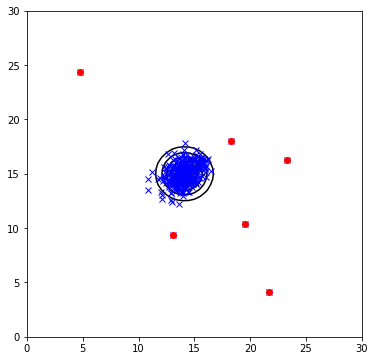

In [13]:
visualizeFit_Outliers(X, mu, sigma2, p, epsilon)

## Multidimensional Outliers

We will use the code from the previous part and apply it to a harder problem in which more features describe each data point and only some features indicate whether a point is an outlier.

In [14]:
# load data
data = scipy.io.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
yval = yval.reshape([len(yval),])

In [15]:
# apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)
# training set
p = multivariateGaussian(X, mu, sigma2)
# cross_validation set
pval = multivariateGaussian(Xval, mu, sigma2)
# find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

C:\Users\xyguo\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


In [16]:
print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 on Cross Validation Set: {}'.format(F1))
print('Outliers found: {}'.format(sum(p< epsilon)))

Best epsilon found using cross-validation: 5.4998481911e-19
Best F1 on Cross Validation Set: 0.615384615385
Outliers found: 117
